In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [38]:
import jax.numpy as jnp
from jax import random
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

,settlement_date,temperature,conditions,precip,cloudcover,humidity,windspeed,nd,pump_storage_pumping,is_holiday
0,2010-01-01 00:00:00,2.5,Partially cloudy,0.0,43.6,75.52,16.2,36566.5,264.5,1.0
1,2010-01-01 01:00:00,0.6,Partially cloudy,0.0,36.1,86.19,14.0,35852.5,289.5,1.0
2,2010-01-01 02:00:00,0.8,Partially cloudy,0.0,48.8,85.14,16.7,34189.5,461.0,1.0
3,2010-01-01 03:00:00,0.7,Partially cloudy,0.0,68.1,83.74,13.9,32453.0,1334.0,1.0
4,2010-01-01 04:00:00,0.4,Partially cloudy,0.0,34.5,83.66,12.2,30450.5,1387.5,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   settlement_date       9048 non-null   object 
 1   temperature           9048 non-null   float64
 2   conditions            9048 non-null   object 
 3   precip                9048 non-null   float64
 4   cloudcover            9048 non-null   float64
 5   humidity              9048 non-null   float64
 6   windspeed             9048 non-null   float64
 7   nd                    9048 non-null   float64
 8   pump_storage_pumping  9048 non-null   float64
 9   is_holiday            9048 non-null   float64
dtypes: float64(8), object(2)
memory usage: 707.0+ KB


None

settlement_date         0
temperature             0
conditions              0
precip                  0
cloudcover              0
humidity                0
windspeed               0
nd                      0
pump_storage_pumping    0
is_holiday              0
dtype: int64

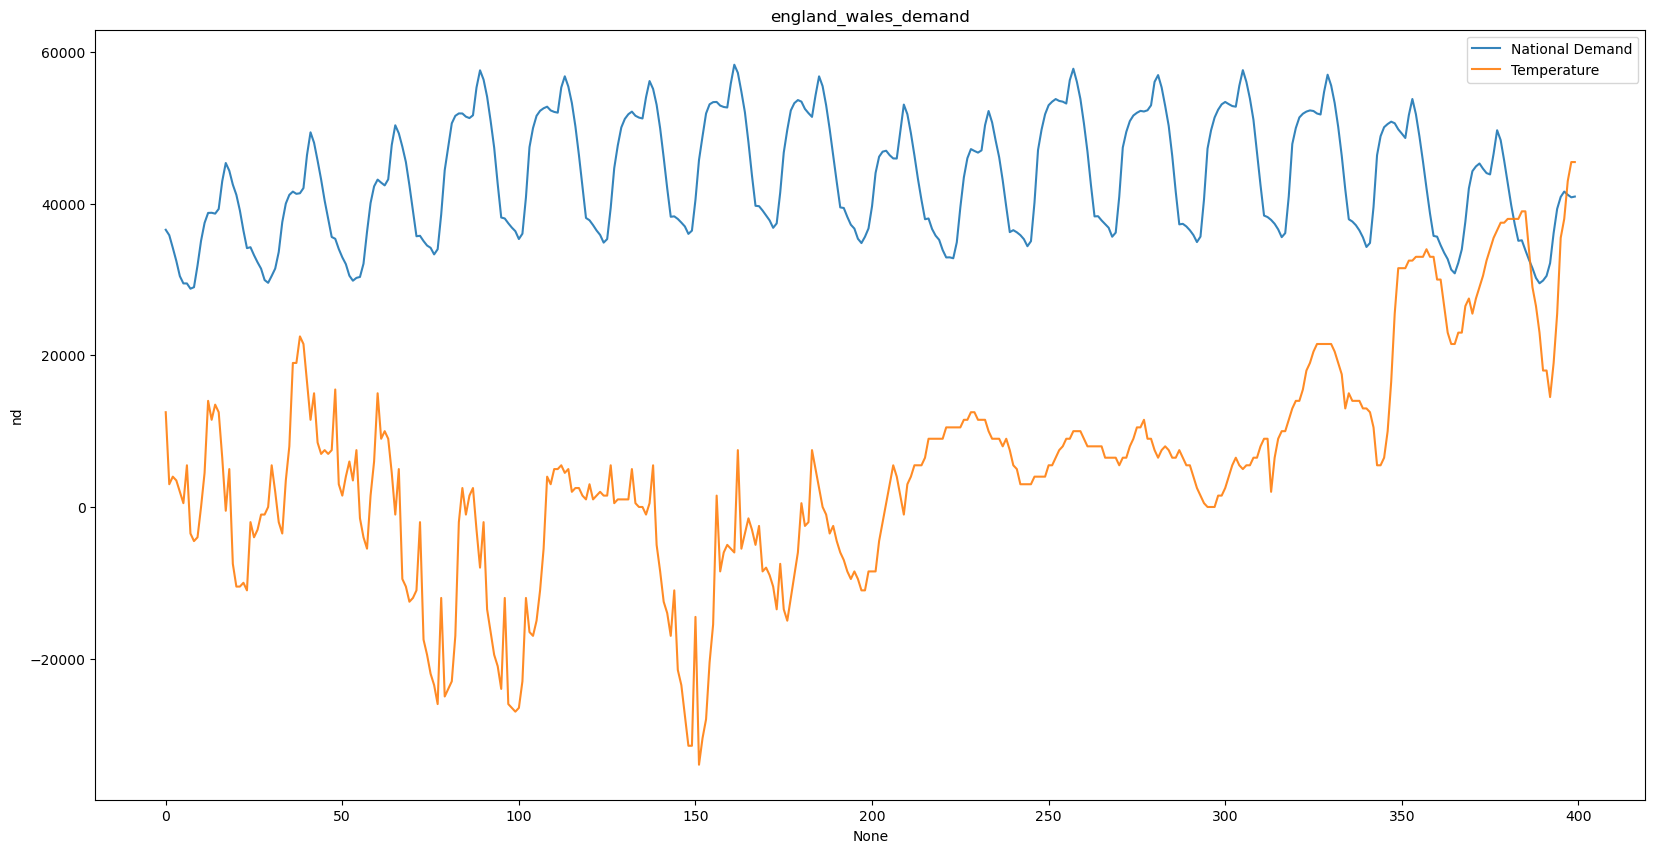

In [104]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

display(data.head())
display(data.info())
display(data.isna().sum())

data_subsample = data[:400]
data_subsample.shape

plt.figure(figsize=(20, 10))
sns.lineplot(x=data_subsample.index, y="nd", data=data_subsample, label="National Demand", alpha = 0.9) 
sns.lineplot(x=data_subsample.index, y=(data_subsample.temperature)*5000, data=data_subsample, label="Temperature", alpha = 0.9) 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

In [105]:
data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

X = data_subsample.drop('nd', axis=1) 
y = data_subsample['nd'] 
X = X[['temperature', 'hour']]

X_train = X[:300]
y_train = y[:300]

X_test = X[300:]
y_test = y[300:]

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_1413/3334649002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


### `Scale data`

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [18]:
pd.DataFrame(X_train_scaled).head()

,temperature,hour
0,1.238721,-1.627632
1,0.340298,-1.483082
2,0.434868,-1.338532
3,0.387583,-1.193982
4,0.245727,-1.049432


In [39]:
t = jnp.linspace(0., 1., 400)

t_train = t[:300]
t_test = t[300:]

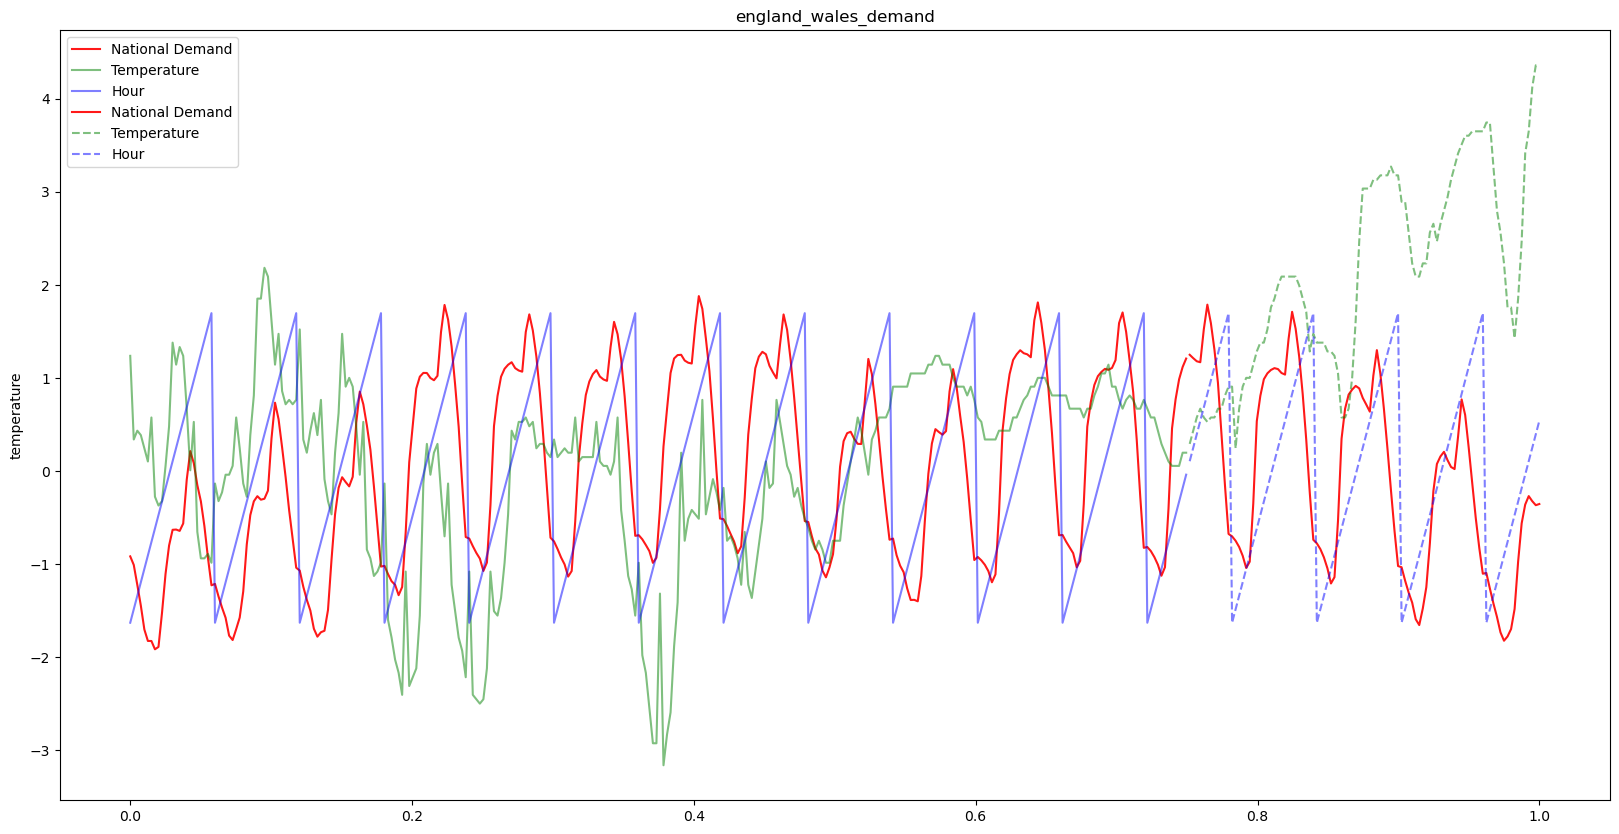

In [40]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=t_train, y=np.squeeze(y_train_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_train, y=X_train_scaled['temperature'], label="Temperature", alpha = 0.5, color='green') 
sns.lineplot(x=t_train, y=X_train_scaled['hour'], label="Hour", alpha = 0.5, color='blue') 

sns.lineplot(x=t_test, y=np.squeeze(y_test_scaled.T), label="National Demand", alpha = 0.9, color='red') 
sns.lineplot(x=t_test, y=X_test_scaled['temperature'], label="Temperature", alpha = 0.5, color='green', ls = '--') 
sns.lineplot(x=t_test, y=X_test_scaled['hour'], label="Hour", alpha = 0.5, color='blue', ls = '--') 
plt.title("england_wales_demand")
plt.grid(False)
plt.legend()
plt.plot();

## `Training Data`


In [21]:
X_train_scaled.head()

,temperature,hour
0,1.238721,-1.627632
1,0.340298,-1.483082
2,0.434868,-1.338532
3,0.387583,-1.193982
4,0.245727,-1.049432


In [25]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

In [26]:
tau = 1
m = 3
embeddings = create_delayed_embeddings(y_train_scaled, tau, m)

In [70]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

In [35]:
offset = tau*m
y_pred_results = {}

layer_widths = [2 + m, 32, 32, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=False)

state = node_model.create_train_state(rng, learning_rate)

i = 300
state = node_model.train(state, t_train[offset : i + offset], jnp.array(y_train_scaled)[offset : i + offset], y_train_scaled[offset], num_epochs = 10000, extra_args=(embeddings[:i],t[offset:i+offset]))

"""for i in [50, 300]:
    print(i)
    state = node_model.train(state, t[:i], u_noisy[:i], y[0], num_epochs = 1000)
#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)"""

Epoch 100, Loss: 285.63306559225117
Epoch 200, Loss: 251.00931165178665
Epoch 300, Loss: 236.57972399366122
Epoch 400, Loss: 228.75693045279434
Epoch 500, Loss: 224.1240220337035
Epoch 600, Loss: 220.82636911352205
Epoch 700, Loss: 217.47985616918376
Epoch 800, Loss: 213.70625082203583
Epoch 900, Loss: 209.5428732476534
Epoch 1000, Loss: 205.17476975613286
Epoch 1100, Loss: 200.7380425250526
Epoch 1200, Loss: 196.23886254763653
Epoch 1300, Loss: 192.01950831867794
Epoch 1400, Loss: 188.6803993249373
Epoch 1500, Loss: 187.95601233838016
Epoch 1600, Loss: 184.24303078570665
Epoch 1700, Loss: 182.70612621445918
Epoch 1800, Loss: 181.17998761825604
Epoch 1900, Loss: 180.7153195809854
Epoch 2000, Loss: 183.09451959305125
Epoch 2100, Loss: 180.73287794837472
Epoch 2200, Loss: 179.44677284681353
Epoch 2300, Loss: 178.56526647148564
Epoch 2400, Loss: 177.54359046363885
Epoch 2500, Loss: 214.67122255108967
Epoch 2600, Loss: 179.5784837954204
Epoch 2700, Loss: 178.0237240080519
Epoch 2800, Loss:

'for i in [50, 300]:\n    print(i)\n    state = node_model.train(state, t[:i], u_noisy[:i], y[0], num_epochs = 1000)\n#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)'

In [36]:
y_train_pred = node_model.neural_ode(state.params, y_train_scaled[offset], t_train[offset:i+offset], state, (embeddings[:i], t_train[offset:i+offset]))

XXX
(297,)


### `Learning just from the delayed embeddings`


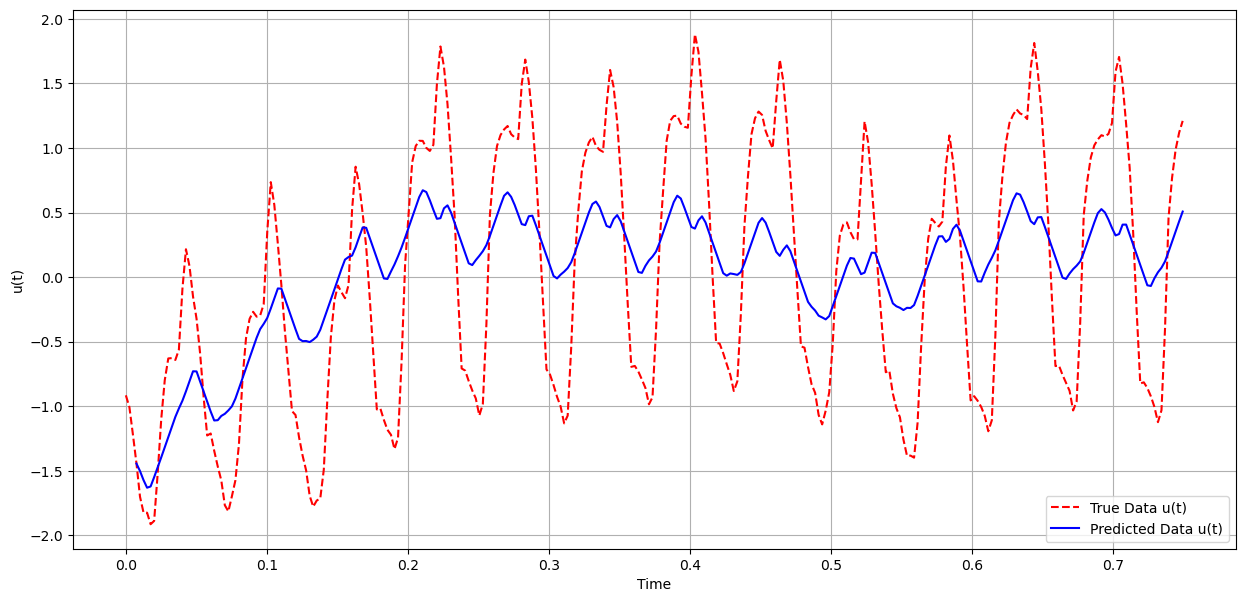

In [37]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(t_train[:i], y_train_scaled[:i], 'r--', label='True Data u(t)') 
# plt.plot(t_test, (y_test_scaled), 'r--', label='True Data u(t)') 
plt.plot(t_train[offset:i+offset], y_train_pred, 'b', label='Predicted Data u(t)') 
# plt.plot(t_test, (y_test_pred), 'b', label='Predicted Data - Test u(t)', ls = "--") 
# plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [81]:
y_embeddings = np.concatenate([y_train_scaled, y_test_scaled], axis=0)
print(y_embeddings.shape)
y_embeddings = np.squeeze(y_embeddings.T)
print(y_embeddings.shape)

(400, 1)
(400,)


In [82]:
print(f"y_train_scaled: {y_train_scaled.shape}")
print(f"y_train_pred: {y_train_pred.shape}")

y_train_scaled: (300, 1)
y_train_pred: (297, 1)


* The last predicted index for the train set is `299`
* Hence, all the indexes starting from 300 have to be set to `null`

In [83]:
for i in range(300, len(y_embeddings)):
    y_embeddings[i] = np.nan

In [84]:
def fetch_embeddings(y, tau, m, index):
    # use slicing to get the embeddings
    return y[index - m * tau : index : tau]

In [85]:
fetch_embeddings(y_train_scaled, tau, m, 303)

array([], shape=(0, 1), dtype=float64)

[ * * * 297 ][ test ]

In [86]:
fetch_embeddings(y_embeddings, tau, m, 300)

array([0.98672805, 1.11884929, 1.20962647])

In [98]:
y_train_pred[-1][0]

Array(0.50758252, dtype=float64)

In [99]:
# the last known value is: 299 
init_value = y_train_pred[-1][0]

# for every test point
# prediction points start at 300
for current_index in range(300, len(y_embeddings)):
    #print(f'Current index is {current_index}')
    # check that the embedding for all the test points is empty
    
    # fetch the embedding for the current index
    embeddings = fetch_embeddings(y_embeddings, tau, m, current_index)
    #print(embeddings)
    if np.isnan(embeddings).any():
        print('There are missing values in the embeddings')

    current_value = node_model.neural_ode(state.params, init_value, t[current_index - 1 : current_index + 1], state, (embeddings, np.nan))[1]
    
    # current value becomes the initial value for the next iteration
    init_value = current_value
    # save the current value to the noisy embeddings
    y_embeddings[current_index] = current_value

Result: [11.88291602]
Result: [11.93974557]
Result: [11.99905865]
Result: [12.0584312]
Result: [12.35641164]
Result: [12.41028289]
Result: [12.47757466]
Result: [12.47724656]
Result: [-31.29585732]
Result: [-31.29550709]
Result: [-31.29341441]
Result: [-31.29214311]
Result: [-31.28527131]
Result: [-31.28395755]
Result: [-31.28227527]
Result: [-31.28227528]
Result: [-31.36679319]
Result: [-31.36672513]
Result: [-31.36624138]
Result: [-31.36595366]
Result: [-31.36439006]
Result: [-31.36408924]
Result: [-31.36370305]
Result: [-31.36370305]
Result: [-28.94416207]
Result: [-28.94325802]
Result: [-28.93526048]
Result: [-28.93006804]
Result: [-28.89716737]
Result: [-28.89018202]
Result: [-28.88099777]
Result: [-28.88099701]
Result: [-28.25542457]
Result: [-28.25480712]
Result: [-28.24789069]
Result: [-28.24333202]
Result: [-28.21319837]
Result: [-28.20664784]
Result: [-28.19798833]
Result: [-28.19798748]
Result: [-27.18641755]
Result: [-27.18625644]
Result: [-27.18321675]
Result: [-27.1807707

In [100]:
y_embeddings.shape
t.shape

(400,)

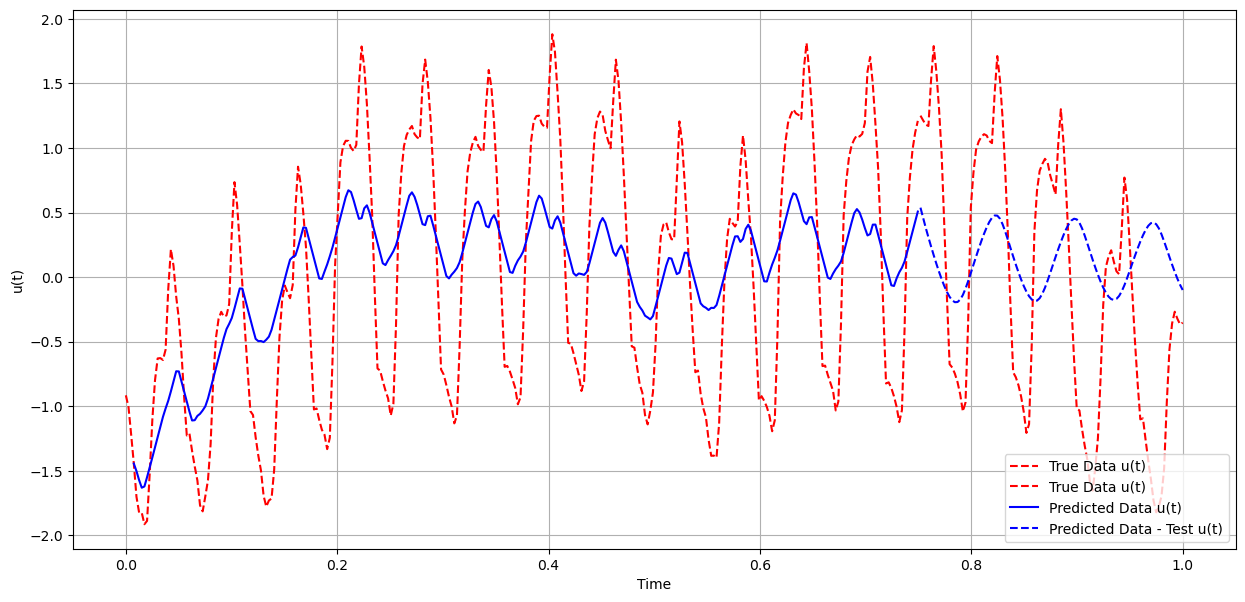

In [102]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(t_train[:i], (y_train_scaled)[:i], 'r--', label='True Data u(t)') 
plt.plot(t_test[:i], (y_test_scaled)[:i], 'r--', label='True Data u(t)') 
# plt.plot(t_test, (y_test_scaled), 'r--', label='True Data u(t)') 
plt.plot(t_train[offset:i+offset], y_train_pred, 'b', label='Predicted Data u(t)') 
plt.plot(t[300:], (y_embeddings[300:]), 'b', label='Predicted Data - Test u(t)', ls = "--") 
# plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

* for Pyomo data, has to be grouped into Chebyshev node points isntead

In [3]:
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [ ]:
state = node_model.train(state, t_train[offset : i + offset], jnp.array(y_train_scaled)[offset : i + offset], y_train_scaled[offset], num_epochs = 3000, extra_args=(embeddings[:i],t[offset:i+offset]))

In [30]:
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [34]:
offset = m*tau
layer_widths = [1 + m, 10, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # 'mu_strategy': 'adaptive', 
          "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, 
          "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_train_scaled[offset:300 + offset]), np.array(t_train[offset:300 + offset]), 
                           np.array(D[offset:300 + offset, offset:300 + offset]),
                           layer_widths, max_iter = 2000, act_func = "tanh", 
                           y_init = np.array(y_train_scaled[offset:300 + offset]), penalty_lambda = 0.0001, 
                           penalty_lambda_input = 0.001,
                           extra_input = np.array(embeddings), 
                           w_init_method = 'xavier', params = params
                           ) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=2000
halt_on_ampl_error=yes
tol=1e-08
print_level=5
dual_inf_tol=1e-05
constr_viol_tol=1e-05
compl_inf_tol=1e-05
check_derivatives_for_naninf=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105968
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    62224

Total number of variables............................:      358
                     variables with only lower bounds:        0
                variables with lower and upper 

ValueError: Cannot load a SolverResults object with bad status: error